### import modules

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 確認GPU是否可用

In [28]:
# 檢測是否有可用的gpu，用cpu計算時間太久
device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"training on device {device}")

training on device cuda


### 找出只有一個channel的圖片

In [29]:
train_data=pd.read_csv('./training_data.csv')
toTensor=v2.Compose([v2.ToTensor()])

def ImgToTensor(path):
  img_pil=Image.open(path)
  img_tensor=toTensor(img_pil)
  return img_tensor

total_img_paths=[os.path.join('./train',i) for i in train_data['Name']]

delete_img_index=[]
for i in range(len(total_img_paths)):
  path=total_img_paths[i]
  img_tensor=ImgToTensor(path)
  if img_tensor.shape[0]!=3:
    delete_img_index.append(i)
    print(path)
    print(img_tensor.shape)

c:\Users\apilab\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


./train\cigmlxzypb6j7nrkv4owd53t19as8qfu.jpg
torch.Size([1, 258, 195])
./train\d53q7ne9rgfpmwh4l2t6czysa8uoikb0.jpg
torch.Size([1, 107, 469])
./train\f7wmyd28ukz6oa0ncb31strgih9p4lv5.jpg
torch.Size([1, 168, 300])
./train\n3xteklymp64q7g2vhjws0bzui15coad.jpg
torch.Size([1, 161, 314])
./train\v43nob1d9x5emtqijwyh0gruf67spz2c.jpg
torch.Size([1, 227, 222])
./train\v9zijlko720h5wspaedq8x6mtfgyn3ru.jpg
torch.Size([1, 290, 174])
./train\zp4x8oje3ryf6vbtcquhs1dingm9kwl5.jpg
torch.Size([1, 60, 600])


#### 以下是只有一個channel的圖片index

In [30]:
delete_img_index=[6504, 6714, 7913, 9031, 9920, 9936, 10445]

#### 刪除只有一個channel的圖片，並重新載入path

In [31]:
train_data=pd.read_csv('./training_data.csv').drop(index=delete_img_index)
train_img_paths=[os.path.join('./train',i) for i in train_data['Name']]
train_img_labels=[i for i in train_data['Type']]

# ==================== add unlabeled and test image ====================
unlabeled_fortrain=pd.read_csv('./unlabeled_img_result1.csv')
for i in range(len(unlabeled_fortrain['Name'])):
  train_img_paths.append(unlabeled_fortrain['Name'][i])
  train_img_labels.append(unlabeled_fortrain['Type'][i])
  
test_for_train=pd.read_csv('./test_to_train1.csv')
for i in range(len(test_for_train['Name'])):
  train_img_paths.append(test_for_train['Name'][i])
  train_img_labels.append(test_for_train['Type'][i])

### 計算用來訓練圖片的平均值與標準差（圖片大小為(224, 224)）

In [32]:
batch_size=len(train_img_paths) # 設定總圖片數
batch=torch.zeros(batch_size,3,224,224) # 建立用來存放圖片的四軸張量
process=v2.Compose([v2.Resize([224,224]),v2.PILToTensor(),v2.ToDtype(torch.float32,True)]) # 先對圖片進行前處理，藉此算標準差、平均值

for i in range(len(train_img_paths)):
  img_arr=Image.open(train_img_paths[i])
  img_tensor=process(img_arr)
  img_tensor=img_tensor[:3]
  batch[i]=img_tensor

imgs=torch.stack([img_tensor for img_tensor in batch],dim=3) # 將圖片堆疊至第三軸
print("mean = "+str(imgs.view(3,-1).mean(dim=1)))
print("std = "+str(imgs.view(3,-1).std(dim=1)))

mean = tensor([0.6456, 0.6119, 0.6006])
std = tensor([0.3108, 0.3127, 0.3165])


#### control the random seed to make sure the result is reproducible

In [7]:
# control random seed
def set_seed(seed=42, loader=None):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
    
def seed_worker(worker_seed = 42):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
set_seed()

#### 定義相關的前處理函式，並觀察結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


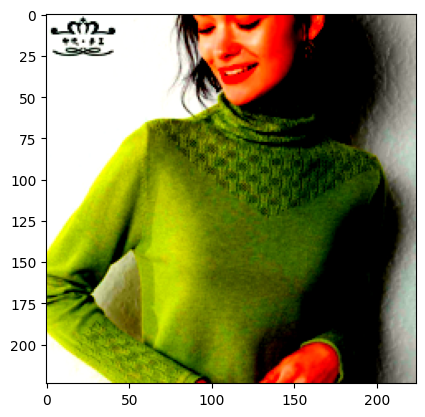

In [33]:
# normalize=v2.Normalize(mean=[0.6364, 0.6053, 0.5959],std=[0.3085, 0.3081, 0.3110]) # 224*224
# normalize=v2.Normalize(mean=[0.6442, 0.6098, 0.5979],std=[0.3109, 0.3129, 0.3170]) # add unlabeled data
normalize=v2.Normalize(mean=[0.6456, 0.6119, 0.6006],std=[0.3108, 0.3127, 0.3165]) # add unlabeled test data1

preprocess=v2.Compose([
  v2.Resize([224,224]),
  v2.PILToTensor(),
  v2.ToDtype(torch.float32,True),
  ])

tarin_pre=v2.Compose([
  # v2.RandomHorizontalFlip(p=0.5),
  # v2.RandomVerticalFlip(p=0.5),
  # v2.RandomRotation(10),
  v2.AutoAugment(),
  normalize
  ])

def default_loader(path):
  img_pil=Image.open(path)
  img_tensor=preprocess(img_pil)
  img_tensor=tarin_pre(img_tensor)
  return img_tensor

img_arr=Image.open('./train/573befa789654604a6e5616d250b66ef.jpg')
img_tensor=preprocess(img_arr)
img_tensor=tarin_pre(img_tensor)

plt.imshow(img_tensor.permute(1,2,0))


### split the data into training set and validation set

In [37]:
x_train,x_val,y_train,y_val=train_test_split(train_img_paths,train_img_labels,test_size=0.1,random_state=42)
len(x_train),len(x_val),len(y_train),len(y_val)

(14220, 1581, 14220, 1581)

### define the data generator

In [38]:
preprocess=v2.Compose([
  v2.Resize([224,224]),
  v2.PILToTensor(),
  v2.ToDtype(torch.float32,True),
  ])

def default_loader(path):
  img_pil=Image.open(path)
  img_tensor=preprocess(img_pil)
  return img_tensor

class ImageDataSet(Dataset):
  def __init__(self,image_path,image_labels,loader=default_loader):
    self.images=image_path
    self.target=image_labels
    self.loader=loader
  def __getitem__(self, index):
    fn=self.images[index]
    img=self.loader(fn)
    target=self.target[index]
    return img,target
  def __len__(self):
    return len(self.images)

In [39]:
# hyperparameters
batch_size=16

In [40]:
train_data=ImageDataSet(x_train,y_train)
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,worker_init_fn=seed_worker,generator=g)

val_data=ImageDataSet(x_val,y_val)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True,worker_init_fn=seed_worker,generator=g)

In [41]:
train_augs=v2.Compose([
      # v2.RandomHorizontalFlip(p=0.5),
      # v2.RandomVerticalFlip(p=0.5),
      # v2.RandomRotation(10),
      v2.AutoAugment(),
      normalize
      ])

test_augs=v2.Compose([normalize])

### define the training loop and evaluation function 

In [42]:

def evaluate(model,loader,loss_fn):
  model.eval()
  correct=0
  total=0
  val_loss=0
  with torch.no_grad():
    for imgs,labels in loader:
      imgs=imgs.cuda()
      imgs=test_augs(imgs)
      labels=labels.cuda()
      outputs=model(imgs)
      loss=loss_fn(outputs,labels)
      val_loss+=loss.item()
      
      _,predicted=torch.max(outputs,dim=1)
      total+=labels.shape[0]
      correct+=(predicted==labels).sum().cpu().item()
  return correct/total,val_loss/len(loader)

# add cutmix and mixup
cutmix = v2.CutMix(num_classes=4)
mixup = v2.MixUp(num_classes=4)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def training_loop(n_epochs,optimizer,model,loss_fn,train_loader,val_loader,scheduler): # 定義訓練的迴圈
  model=model.cuda() # 將model移到gpu進行計算
  test_acc_max=0
  training_loss_list=[]
  val_loss_list=[]
  train_acc_list=[]
  test_acc_list=[]
  for epoch in range(1,n_epochs+1):
    loss_train=0.0
    start=time.time()
    image_preds_all=[]
    image_targets_all=[]
    for index, (imgs, labels) in enumerate(train_loader):
      imgs, labels = cutmix_or_mixup(imgs, labels)
      
      imgs=imgs.cuda() # 將imgs移到gpu進行計算
      imgs=train_augs(imgs)
      labels=labels.cuda() # 將labels移到gpu進行計算

      outputs=model(imgs)
      loss=loss_fn(outputs,labels)
      optimizer.zero_grad() # 梯度歸零，防止梯度疊加
      loss.backward()
      optimizer.step() # 更新資料
      loss_train+=loss.item()
      
      image_preds_all += [torch.argmax(outputs, 1).detach().cpu().numpy()]
      image_targets_all += [torch.argmax(labels, 1).detach().cpu().numpy()]
      
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    accuracy = (image_preds_all==image_targets_all).mean()
    
    test_acc,val_loss=evaluate(model,val_loader,loss_fn)
    training_loss_list.append(loss_train/len(train_loader))
    val_loss_list.append(val_loss)
    train_acc_list.append(accuracy)
    test_acc_list.append(test_acc)
    if scheduler.__module__ == 'torch.optim.lr_scheduler':
      scheduler.step(val_loss)
    if test_acc>=test_acc_max:
      test_acc_max=test_acc
      torch.save(model.state_dict(),'./model.pth')
    print('Epoch {}, Training loss {:.4f}, Train_acc {:.2f}, Test_acc {:.4f}, time {:.2f} sec'\
      .format(epoch,loss_train/len(train_loader),accuracy,test_acc,time.time()-start))
  
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  plt.plot(training_loss_list, label='train_loss')
  plt.plot(val_loss_list, label='val_loss')
  plt.xlabel("Epoch")
  plt.ylabel("Training Loss")
  plt.legend()
  plt.subplot(122)
  plt.plot(train_acc_list, label='train_acc')
  plt.plot(test_acc_list, label='test_acc')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.tight_layout()
  plt.show()

In [43]:
def customizeFC(input_size):
  return nn.Sequential(
    nn.Linear(input_size,256),
    nn.ReLU(),
    nn.Linear(256,4),
  )

# ============ EfficientNet_B4 ============ 
# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# model=models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
# for param in model.parameters():
#   param.requires_grad=False
# model.classifier=customizeFC(1792)
# for param in model.classifier[1].parameters():
#   param.requires_grad=True
# print(model)

# ============ RegNet_Y_16GF ============ 
# batch-> 16
model=models.regnet_y_16gf(weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
model.fc=customizeFC(3024)

Epoch 1, Training loss 0.9698, Train_acc 0.70, Test_acc 0.8937, time 258.10 sec
Epoch 2, Training loss 0.8764, Train_acc 0.74, Test_acc 0.8798, time 248.90 sec
Epoch 3, Training loss 0.8227, Train_acc 0.77, Test_acc 0.8982, time 286.29 sec
Epoch 4, Training loss 0.7973, Train_acc 0.78, Test_acc 0.8963, time 242.60 sec
Epoch 5, Training loss 0.7782, Train_acc 0.78, Test_acc 0.8975, time 258.36 sec
Epoch 6, Training loss 0.7726, Train_acc 0.79, Test_acc 0.9083, time 270.87 sec
Epoch 7, Training loss 0.7379, Train_acc 0.81, Test_acc 0.9039, time 266.89 sec
Epoch 8, Training loss 0.7366, Train_acc 0.81, Test_acc 0.9013, time 270.82 sec
Epoch 9, Training loss 0.7220, Train_acc 0.81, Test_acc 0.9064, time 273.81 sec
Epoch 10, Training loss 0.7224, Train_acc 0.81, Test_acc 0.9127, time 274.21 sec
Epoch 11, Training loss 0.7023, Train_acc 0.83, Test_acc 0.9108, time 268.67 sec
Epoch 00012: reducing learning rate of group 0 to 2.0000e-06.
Epoch 12, Training loss 0.7007, Train_acc 0.82, Test_acc

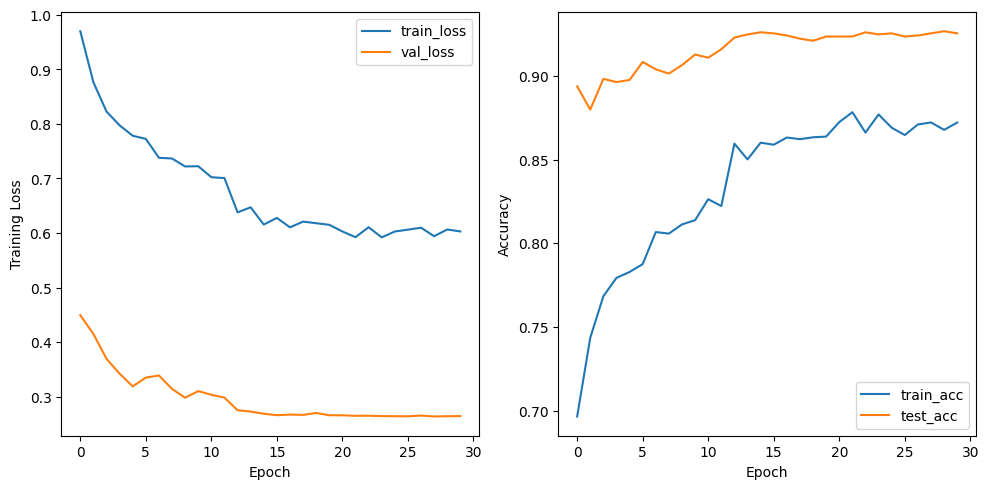

In [44]:
optimizer=torch.optim.Adam(model.parameters(),lr=2e-5)
loss_fn=nn.CrossEntropyLoss() # 設定損失函數
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
training_loop(n_epochs=30,optimizer=optimizer,model=model,loss_fn=loss_fn,train_loader=train_loader,val_loader=val_loader,scheduler=scheduler)

### 找出 unlabeled 中只有一個channel的圖片

In [45]:
unlabeled_path='./unlabeled_data'
unlabeled_filename=[name for name in os.listdir(unlabeled_path) if os.path.splitext(name)[-1]=='.jpg']
unlabeled_img_paths=[os.path.join(unlabeled_path,i) for i in unlabeled_filename if i!="oIQiOVTSKZ9741837007.jpg"]

model=models.regnet_y_16gf()
model.fc=customizeFC(3024)
model.load_state_dict(torch.load('./model.pth'))
model=model.cuda()
model.eval()

preprocess=v2.Compose([
    v2.Resize([224,224]),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32,True),
    normalize
    ]) # 重新定義前處理，並加入平均值和標準差

def default_loader(path):
  img_pil=Image.open(path)
  img_tensor=preprocess(img_pil)
  return img_tensor

toTensor=v2.Compose([v2.ToTensor()])
def ImgToTensor(path):
  img_pil=Image.open(path)
  img_tensor=toTensor(img_pil)
  return img_tensor

delete_img_index=[]
for i in range(len(unlabeled_img_paths)):
  path=unlabeled_img_paths[i]
  img_tensor=ImgToTensor(path)
  if img_tensor.shape[0]!=3:
    delete_img_index.append(i)
    print(path)
    print(img_tensor.shape)
    
unlabeled_img_paths=[i for j, i in enumerate(unlabeled_img_paths) if j not in delete_img_index]

c:\Users\apilab\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


./unlabeled_data\ALyuecBuqM5126861610.jpg
torch.Size([1, 225, 225])
./unlabeled_data\ASYoBFKvba0639799117.jpg
torch.Size([1, 161, 314])
./unlabeled_data\bqqLWGhRyH1038087004.jpg
torch.Size([1, 205, 246])
./unlabeled_data\brLasTemLa6931752500.jpg
torch.Size([1, 225, 225])
./unlabeled_data\CztShfQozB3062510216.jpg
torch.Size([1, 153, 152])
./unlabeled_data\DEsvlKUbWD0955792696.jpg
torch.Size([1, 136, 370])
./unlabeled_data\DTrCcjxFPF2298846714.jpg
torch.Size([1, 235, 200])
./unlabeled_data\EIRhZVLqCY6686849509.jpg
torch.Size([1, 225, 225])
./unlabeled_data\FLWnAGSsWO4306204338.jpg
torch.Size([1, 208, 200])
./unlabeled_data\hVTZCZJZdy2470697935.jpg
torch.Size([1, 208, 242])
./unlabeled_data\iXvhQPgIxS6101158641.jpg
torch.Size([1, 228, 221])
./unlabeled_data\jciNqdUxVN1600912387.jpg
torch.Size([1, 107, 469])
./unlabeled_data\jZetizTbIC9206913554.jpg
torch.Size([1, 181, 278])
./unlabeled_data\KSCYixKysc6460789057.jpg
torch.Size([1, 225, 225])
./unlabeled_data\MeVPkjvBvf3807640095.jpg
torch.

### use model to label unlabeled data

In [46]:
result_path=[]
result=[]
lower_90_num=0

for path in unlabeled_img_paths:
  img_tensor=default_loader(path)
  img_tensor=img_tensor.unsqueeze(0)
  img_tensor=img_tensor.cuda()
  output=model(img_tensor)
  output=torch.softmax(output,dim=1)
  max_score,predicted=torch.max(output,dim=1)
  if max_score>0.9:
    result_path.append(path)
    result.append(predicted.item())
  else:
    lower_90_num+=1
    
print("lower_90_num = ",lower_90_num)
unlabeled_img_result_df=pd.DataFrame({'Name':result_path,'Type':result})
unlabeled_img_result_df.to_csv('./unlabeled_img_result.csv',index=False)

lower_90_num =  2127


### use model to label test data

In [47]:
# # All RGB
test_path='./test/'
test_filename=[name for name in os.listdir(test_path) if os.path.splitext(name)[-1]=='.jpg']
test_img_paths=[os.path.join(test_path,i) for i in test_filename]

model=models.regnet_y_16gf()
model.fc=customizeFC(3024)

model.load_state_dict(torch.load('./model.pth'))
model=model.cuda()
model.eval()

preprocess=v2.Compose([
    v2.Resize([224,224]),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32,True),
    normalize
    ])

def default_loader(path):
  img_pil=Image.open(path)
  img_tensor=preprocess(img_pil)
  return img_tensor

lower_90_num=0
result_path=[]
result=[]
for path in test_img_paths:
  img_tensor=default_loader(path)
  img_tensor=img_tensor.unsqueeze(0)
  img_tensor=img_tensor.cuda()
  output=model(img_tensor)
  output=torch.softmax(output,dim=1)
  max_score,predicted=torch.max(output,dim=1)
  if max_score>0.90:
    result_path.append(path)
    result.append(predicted.item())
  else:
    lower_90_num+=1

print("lower_90_num = ",lower_90_num)
test_img_result_df=pd.DataFrame({'Name':result_path,'Type':result})
test_img_result_df.to_csv('./test_to_train.csv',index=False)

lower_90_num =  754


## predict the testing data

In [48]:
test_path='./test/'
test_filename=[name for name in os.listdir(test_path) if os.path.splitext(name)[-1]=='.jpg']
test_img_paths=[os.path.join(test_path,i) for i in test_filename]

model=models.regnet_y_16gf()
model.fc=customizeFC(3024)

model.load_state_dict(torch.load('./model.pth'))
model=model.cuda()
model.eval()

preprocess=v2.Compose([
  v2.Resize([224,224]),
  v2.PILToTensor(),
  v2.ToDtype(torch.float32,True),
  normalize
  ])

def default_loader(path):
  img_pil=Image.open(path)
  img_tensor=preprocess(img_pil)
  return img_tensor

result=[]
for path in test_img_paths:
  img_tensor=default_loader(path)
  img_tensor=img_tensor.unsqueeze(0)
  img_tensor=img_tensor.cuda()
  output=model(img_tensor)
  _,predicted=torch.max(output,dim=1)
  result.append(predicted.item())

result_df=pd.DataFrame({'Name':test_filename,'Type':result})
result_df.to_csv('pred.csv',index=False)